In [13]:
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
import numpy as np

from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cross_validation import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.base import clone
from sklearn.utils import shuffle


In [28]:
def build_model(hyper_parameters):

    net = NeuralNet(
        layers=[
            ('input', layers.InputLayer),
            ('conv1', layers.Conv2DLayer),
            ('pool1', layers.MaxPool2DLayer),
            ('conv2', layers.Conv2DLayer),
            ('pool2', layers.MaxPool2DLayer),
            ('conv3', layers.Conv2DLayer),
            ('pool3', layers.MaxPool2DLayer),
            ('hidden4', layers.DenseLayer),
            ('hidden5', layers.DenseLayer),
            ('output', layers.DenseLayer),
            ],
        input_shape=(None, 3, 64, 64),
        verbose=1,
        **hyper_parameters
        )
    return net

## Load data & pre-processing

In [29]:
# Load X
data = np.load("data_64x64.npy.npz")
X = (data['X'] / 255.).astype(np.float32)

# Load y
file_y = "latin_labels" # or "french_labels"
y = map(lambda l:l.decode("utf-8")[0:-1], open(file_y).readlines())
y = np.array(y, dtype='unicode')
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)
y = y.astype(np.int32)

counts = Counter(y)
classes = counts.keys()
nb = counts.values()

most_frequent_classes = map(lambda (c, n):c,
                            sorted( zip(classes, nb), key=lambda (c, n):n, reverse=True))
# take 5 most frequent classes
nb_most_freq = 5
most_frequent_classes = most_frequent_classes[0:nb_most_freq]

# construct a filter of examples according to the most frequent classes
most_freq = (y == most_frequent_classes[0])
for c in most_frequent_classes[1:]:
    most_freq |= (y == c)

## Visualizations

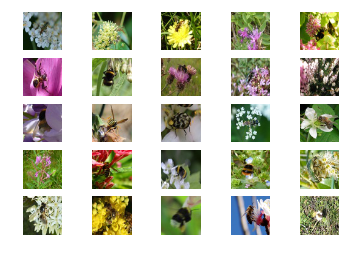

In [30]:
# Show some random insects

nb_row = 5
nb_col = 5

fig = plt.figure()
k = 0
for r in range(nb_row):
    for c in range(nb_col):
        ax = fig.add_subplot(nb_row, nb_col, k + 1)
        sample_id = np.random.randint(0, X.shape[0])
        ax.axis('off')
        #plt.title(y[sample_id])
        ax.imshow(X[sample_id])
        k += 1
plt.show()

## Define hyper-parameters & build the model

In [31]:
hyper_parameters = dict(
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,
    max_epochs=30,
)

net = build_model(hyper_parameters)

## Split the data & adapt it to nolearn

In [33]:
X_, y_ = X[most_freq], y[most_freq]
X_ = X_.transpose((0, 3, 1, 2))

X_, y_ = shuffle(X_, y_)
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.25)

## Training

In [ ]:
print(X_train.shape)
net.fit(X_train, y_train)

y_pred = net.predict(X_test)
score = accuracy_score(y_pred, y_test)
print(score)
print(confusion_matrix(y_pred, y_test))
print(classification_report(y_pred, y_test))

(13013, 3, 64, 64)
  input             	(None, 3, 64, 64)   	produces   12288 outputs
  conv1             	(None, 32, 62, 62)  	produces  123008 outputs
  pool1             	(None, 32, 31, 31)  	produces   30752 outputs
  conv2             	(None, 64, 30, 30)  	produces   57600 outputs
  pool2             	(None, 64, 15, 15)  	produces   14400 outputs
  conv3             	(None, 128, 14, 14) 	produces   25088 outputs
  pool3             	(None, 128, 7, 7)   	produces    6272 outputs
  hidden4           	(None, 500)         	produces     500 outputs
  hidden5           	(None, 500)         	produces     500 outputs
  output            	(None, 30)          	produces      30 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------